# Análise da razão entre o valor total comprovado e captado de um projeto
---

Issue: [#201](https://github.com/lappis-unb/salic-ml/issues/201) Explorar nova métrica: razão entre o valor total comprovado e o valor total captado de um projeto.

## Objetivos

Analisar a razão entre o valor total comprovado e o valor total captado para todos os projetos culturais, sem delimitações de segmento ou produto cultural. Nesta análise, serão utilizados modelos para identificar projetos onde tal métrica é anormal com relação aos demais projetos.

A metodolgia e modelos aplicados neste notebook para identificar projetos considerados anômalos com relação a esta métrica é a mesma aplicada no notebook `notebooks/report/analysis_of_approved_funds.ipynb`, relativo à métrica "valor total aprovado para um projeto".

---
## Preparação

Será gerado um dataset contendo as informações abaixo relativas a cada projeto que tenha pelo menos um comprovante.
* Valor total captado
* Valor total comprovado
* Dados derivados dos itens acima

#### Importando módulos necessários

In [1]:
%pylab inline
import scipy
import pandas as pd
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


#### 1. Carregando dataset com o valor total captado por projeto

In [2]:
df_raised = pd.read_csv('../../data/raw/planilha_captacao.csv', low_memory=False)
print(df_raised.columns)
print(df_raised.shape)

Index(['Idcaptacao', 'Pronac', 'Segmento', 'NumeroRecibo', 'CgcCpfMecena',
       'TipoApoio', 'MedidaProvisoria', 'DtChegadaRecibo', 'DtRecibo',
       'CaptacaoReal', 'CaptacaoUfir', 'logon', 'isBemServico'],
      dtype='object')
(426036, 13)


#### Gerando dataset com o valor captado

In [3]:
raised = df_raised[['Pronac', 'CaptacaoReal']]
raised = raised.groupby(['Pronac']).sum()
raised = raised.sort_values(by='CaptacaoReal', ascending=False)
print(raised.shape)
raised.head()

(34330, 1)


,CaptacaoReal
Pronac,
107097,36255500.30
87684,35684235.27
88016,30660000.00
78984,29500000.00
108960,29500000.00


#### 2. Carregando dataset com o valor total comprovado

In [4]:
df_proven = pd.read_csv('../../data/raw/planilha_comprovacao.csv', low_memory=False)
print(df_proven.columns)
print(df_proven.shape)

Index(['PRONAC', 'idPlanilhaAprovacao', 'idComprovantePagamento', 'IdPRONAC',
       'idSegmento', 'cdProduto', 'cdEtapa', 'cdUF', 'UF', 'cdCidade',
       'idPlanilhaItem', 'Item', 'DataProjeto', 'nrComprovante', 'nrSerie',
       'nrCNPJCPF', 'nmFornecedor', 'proponenteCgcCpf', 'tpDocumento',
       'dtPagamento', 'dtEmissao', 'tpFormaDePagamento',
       'nrDocumentoDePagamento', 'idArquivo', 'dsJustificativaProponente',
       'dsOcorrenciaDoTecnico', 'stItemAvaliado', 'stAvaliacao',
       'vlComprovacao'],
      dtype='object')
(355664, 29)


#### Gerando dataset com o valor comprovado

In [5]:
proven = df_proven[['PRONAC', 'idComprovantePagamento', 'vlComprovacao']]
proven = proven.drop_duplicates(subset=['PRONAC', 'idComprovantePagamento'])
proven = proven.drop(columns=['idComprovantePagamento'])
proven = proven.groupby(['PRONAC']).sum()
proven = proven.sort_values(by='vlComprovacao', ascending=False)
print(proven.shape)
proven.head()

(2907, 1)


,vlComprovacao
PRONAC,
1410875,14577034.70
163824,14156633.49
158607,13912058.17
163306,11477852.20
164188,9758913.05


#### 3. Gerando dataset final com os valores captado e comprovado dos projetos

Neste passo, todos os projetos sem nenhum comprovante são descartados e todos os projetos com o valor de comprovação maior que o valor de captação também são descartados. É preciso investigar o porquê de isso acontecer. Uma hipótese é que o proponente pode comprovar tudo o que foi aprovado, mesmo que nem todo o aprovado tenha sido captado.

In [6]:
proven_raised = proven.join(raised)
proven_raised['provenRaisedRatio'] = proven_raised['vlComprovacao'] / proven_raised['CaptacaoReal']
print('# projects where vlComprovacao > CaptacaoReal = ', sum(proven_raised['provenRaisedRatio'] > 1))
proven_raised = proven_raised[proven_raised['provenRaisedRatio'] <= 1]
print(proven_raised.shape)
proven_raised.head()

# projects where vlComprovacao > CaptacaoReal =  913
(1994, 3)


,vlComprovacao,CaptacaoReal,provenRaisedRatio
PRONAC,,,
1410875,14577034.70,14730000.00,0.989615
163824,14156633.49,16441868.69,0.861011
158607,13912058.17,14000000.00,0.993718
163306,11477852.20,14935255.19,0.768507
164188,9758913.05,12751278.07,0.765328


---
## Desenvolvimento

#### Gerando uma lista da razão entre os valores comprovado e captado dos projetos

In [7]:
projects = proven_raised['provenRaisedRatio']
print(projects.dropna().shape)
display(projects.head())

(1994,)


PRONAC
1410875    0.989615
163824     0.861011
158607     0.993718
163306     0.768507
164188     0.765328
Name: provenRaisedRatio, dtype: float64

#### Gerando visualizações dos dados acima

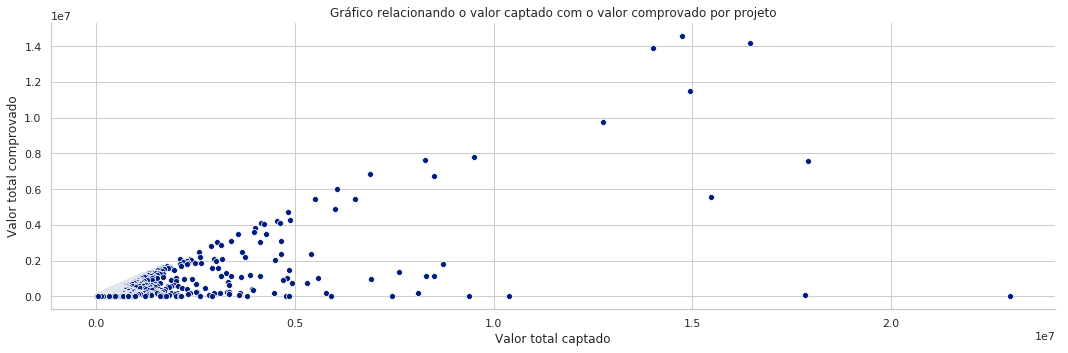

In [8]:
sns.set(style='whitegrid', palette='dark')
sns.relplot(x='CaptacaoReal', y='vlComprovacao', data=proven_raised, aspect=3)
plt.xlabel('Valor total captado')
plt.ylabel('Valor total comprovado')
plt.title('Gráfico relacionando o valor captado com o valor comprovado por projeto');

Média da distribuição: 0.72
Desvio padrão da distribuição: 0.34



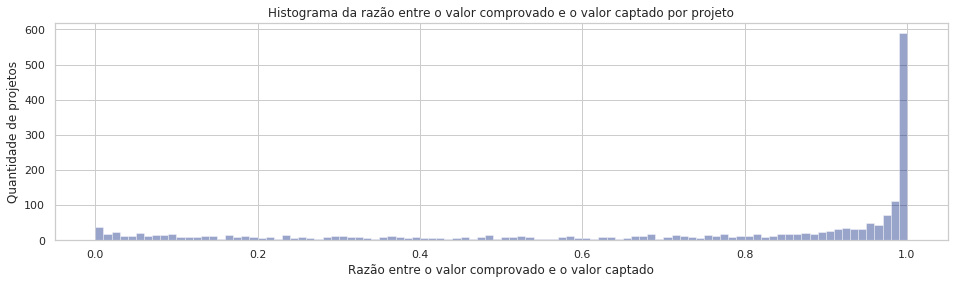

In [9]:
sns.set(style='whitegrid', palette='dark')
f, ax = plt.subplots(figsize=(16,4))

sns.distplot(projects, bins=100, kde=False)
plt.title('Histograma da razão entre o valor comprovado e o valor captado por projeto')
plt.ylabel('Quantidade de projetos')
plt.xlabel('Razão entre o valor comprovado e o valor captado')
plt.grid(True)

expected_mean = np.mean(projects)
expected_std = np.std(projects)

print('Média da distribuição: %.2lf' % expected_mean)
print('Desvio padrão da distribuição: %.2lf\n' % expected_std)

#### Separando os conjuntos de treino e teste

In [10]:
from sklearn.model_selection import train_test_split
projects_train, projects_test = train_test_split(projects, test_size=0.3)

display(projects_train.head())
display(projects_test.head())

PRONAC
162633     0.527455
164365     0.999340
160041     0.734623
1310923    0.948254
1413905    0.990676
Name: provenRaisedRatio, dtype: float64

PRONAC
1410703    0.899592
154096     0.213613
1310344    0.123297
170843     0.586000
170873     0.245108
Name: provenRaisedRatio, dtype: float64

#### Implementando função auxiliar para mostrar os gráficos e estatísticas referentes a cada um dos modelos explorados

In [11]:
import time
def show_stats(model, train_set, test_set, bin_size=1):
    begin = time.time()
    model.fit(train_set)
    print('Tempo de treinamento: %.3lf (s)' % (time.time() - begin))
    begin = time.time()
    is_inlier = model.predict(test_set)
    print('Tempo de teste: %.3lf (s)' % (time.time() - begin))

    contamination_found = sum(~is_inlier) / len(test_set)
    print('Percentual de outliers esperado: %.2lf%%' % (100 * model.contamination))
    print('Percentual de outliers encontrado: %.2lf%%' % (100 * contamination_found))

    sns.set(style='whitegrid', palette='dark')
    f, ax = plt.subplots(figsize=(16,4))

    inliers = test_set[is_inlier]
    bins = max(1, int((max(inliers) - min(inliers)) // bin_size) + 1)
    sns.distplot(inliers, label='inliers', color='b', kde=False, bins=bins)

    outliers = test_set[~is_inlier]
    bins = max(1, int((max(outliers) - min(outliers)) // bin_size) + 1)
    sns.distplot(outliers, label='outliers', color='r', kde=False, bins=bins)
    
    if hasattr(model.model, 'pdf'):
        x = np.linspace(min(test_set), max(test_set), 1000)
        y = model.model.pdf(x)
        if hasattr(model, 'transform'):
            y = model.model.pdf(model.transform(x))
        plt.plot(x,  bin_size * len(test_set) * y, label='PDF')

    plt.legend(frameon=True)
    plt.ylabel('# projects')
    plt.xlabel('numItemsWReceipts / numItems')
    plt.title('Inlier/Outlier division')

#### Implementando funções auxiliares para os modelos utilizados

In [12]:
def bisect(f, a=0, b=1, rtol=1e-6, maxiter=40):
    # simplified scipy.optimize.bisect
    niter, x0 = (0, a)
    while niter < maxiter:
        niter += 1
        x0 = (b + a) / 2
        f0 = f(x0)
        if abs(f0) < rtol:
            break
        elif f0 < 0:
            b = x0
        else:
            a = x0
    return x0

def find_threshold(model, X, contamination):
    h = max(X) - min(X)
    _X = np.linspace(min(X) - h, max(X) + h, int(1e3))
    dx = _X[1] - _X[0]
    pdf = model.pdf(_X)
    def f(threshold):
        _pdf = pdf.copy()
        _pdf[_pdf <= threshold] = 0
        I = scipy.integrate.simps(_pdf, dx=dx)
        return I - (1.0 - contamination)
    return bisect(f)

#### Modelo Gaussiano

Tempo de treinamento: 0.013 (s)
Tempo de teste: 0.001 (s)
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 10.52%


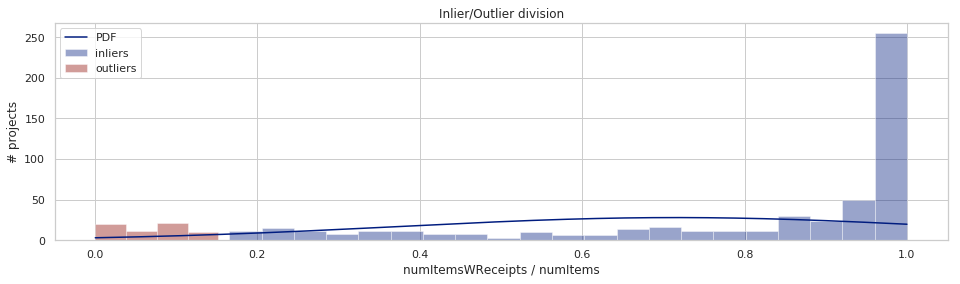

In [13]:
class Gaussian:
    def __init__(self, contamination=0.1):
        self.contamination = contamination

    def fit(self, X):
        # Generate model
        mean, std = scipy.stats.norm.fit(X)
        self.model = scipy.stats.norm(mean, std)
        # Find threshold
        self.threshold = find_threshold(self.model, X, self.contamination)
        return self
    
    def predict(self, X):
        is_inlier = (self.model.pdf(X) > self.threshold)
        return is_inlier

show_stats(Gaussian(), projects_train, projects_test, bin_size=0.04)

#### Modelo Log-normal

Tempo de treinamento: 0.105 (s)
Tempo de teste: 0.002 (s)
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 10.52%


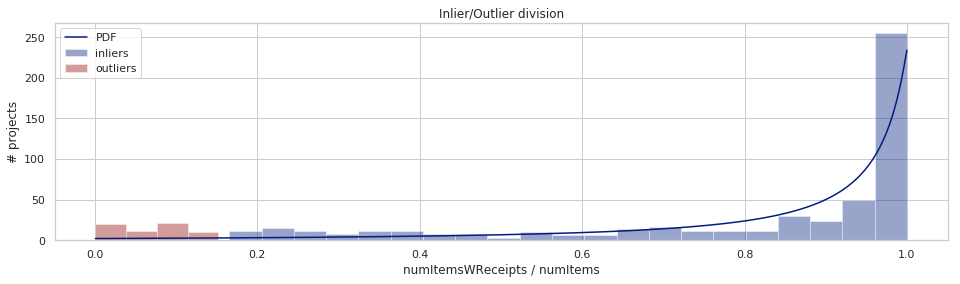

In [14]:
class Lognormal:
    def __init__(self, contamination=0.1, transform=lambda X: X):
        self.contamination = contamination
        self.transform = transform

    def fit(self, X):
        # Generate model
        X = self.transform(X)
        s, loc, scale = scipy.stats.lognorm.fit(X, floc=0)
        self.model = scipy.stats.lognorm(np.std(np.log(X)), loc=loc, scale=scale)
        # Find threshold
        self.threshold = find_threshold(self.model, X, self.contamination)
        return self
    
    def predict(self, X):
        X = self.transform(X)
        is_inlier = (self.model.pdf(X) > self.threshold)
        return is_inlier

show_stats(Lognormal(transform=lambda X: 1.01-X), projects_train, projects_test, bin_size=0.04)

#### Modelo Gamma

Tempo de treinamento: 0.025 (s)
Tempo de teste: 0.001 (s)
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 0.50%


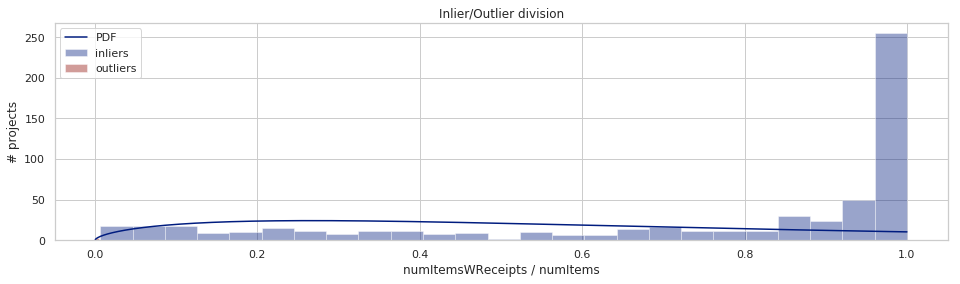

In [15]:
class Gamma:
    def __init__(self, contamination=0.1):
        self.contamination = contamination

    def fit(self, X):
        # Generate model
        params = scipy.stats.gamma.fit(X, floc=0)
        self.model = scipy.stats.gamma(*params)
        # Find threshold
        self.threshold = find_threshold(self.model, X, self.contamination)
        return self
    
    def predict(self, X):
        is_inlier = (self.model.pdf(X) > self.threshold)
        return is_inlier
    
show_stats(Gamma(), projects_train, projects_test, bin_size=0.04)

#### Modelo de Estimativa de Densidade Kernel com Kernel Gaussiano

Tempo de treinamento: 0.210 (s)
Tempo de teste: 0.104 (s)
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 6.01%


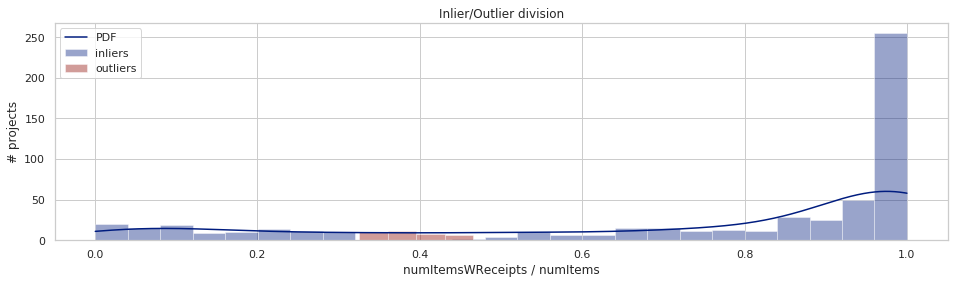

In [16]:
class KDE:
    def __init__(self, contamination=0.1, kernel='gauss'):
        self.contamination = contamination
        self.kernel = kernel

    def fit(self, X):
        # Generate model
        if self.kernel == 'gauss':
            self.model = scipy.stats.gaussian_kde(X)
        else:
            raise AttributeError('Kernel function not found')
        # Find threshold
        self.threshold = find_threshold(self.model, X, self.contamination)
        return self
    
    def predict(self, X):
        is_inlier = (self.model.pdf(X) > self.threshold)
        return is_inlier
    
show_stats(KDE(), projects_train, projects_test, bin_size=0.04)

#### Estimador por Fator de Anomalia Local (LOF)

Tempo de treinamento: 0.032 (s)
Tempo de teste: 0.008 (s)
Percentual de outliers esperado: 10.00%
Percentual de outliers encontrado: 55.59%


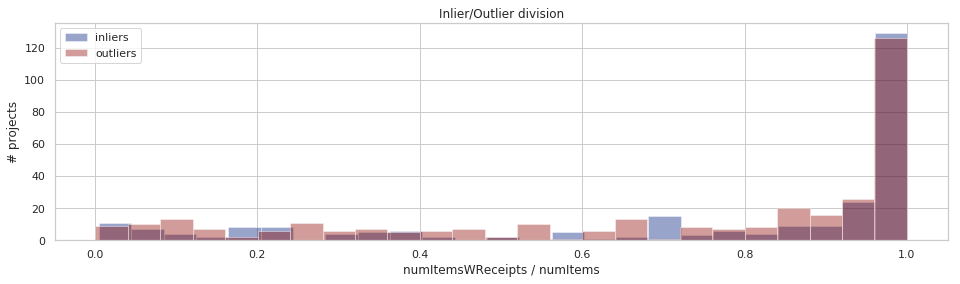

In [17]:
from sklearn.neighbors import LocalOutlierFactor
class LOF:
    def __init__(self, contamination=0.1, n_neighbors=20):
        self.contamination = contamination
        self.n_neighbors = n_neighbors

    def fit(self, X):
        # Transform data into a 2D array
        X = self._1Dto2D(X)
        # Get inliers of the training set with LOF Outlier Detection
        lof_OD = LocalOutlierFactor(contamination=self.contamination,
                                    n_neighbors=self.n_neighbors)
        y = lof_OD.fit_predict(X)
        X = X[y == 1, :]
        # Train model with LOF Novelty Detection, using train set inliers
        # Parameter 'contamination' does not matter at this point
        self.model = LocalOutlierFactor(novelty=True, contamination=0.5)
        self.model = self.model.fit(X)
        return self
    
    def predict(self, X):
        X = self._1Dto2D(X)
        is_inlier = (self.model.predict(X) == 1)
        return is_inlier
    
    def _1Dto2D(self, X):
        shape = (len(X),1)
        return np.hstack([np.array(X.tolist()).reshape(shape), np.zeros(shape)])

show_stats(LOF(), projects_train, projects_test, bin_size=0.04)

#### Avaliando a contaminação média encontrada

Nesta seção, os diversos modelos implementados acima são aplicados a várias escolhas aleatórias de conjuntos de treino/teste. Ao final, o desempenho de cada modelo é avaliado.

In [18]:
models = [{
    'name': 'Gaussian',
    'curve': Gaussian(),
    'results': []
},{
    'name': 'Log-normal',
    'curve': Lognormal(transform=lambda X: 1.01-X),
    'results': []
},{
    'name': 'Gamma',
    'curve': Gamma(),
    'results': []
},{
    'name': 'KDE-Gauss',
    'curve': KDE(),
    'results': []
},{
    'name': 'LOF',
    'curve': LOF(),
    'results': []
}]

for i in range(100):
    # Separate train and test sets
    projects_train, projects_test = train_test_split(projects, test_size=0.3)
    
    # Get results for each model
    for model in models:
        inlier_filter = (model['curve'].fit(projects_train).predict(projects_test))
        contamination_found = sum(~inlier_filter) / len(projects_test)
        model['results'].append(100 * contamination_found)

Média Gaussian: 12.64%
Média Log-normal: 13.89%
Média Gamma: 2.01%
Média KDE-Gauss: 6.27%
Média LOF: 58.50%


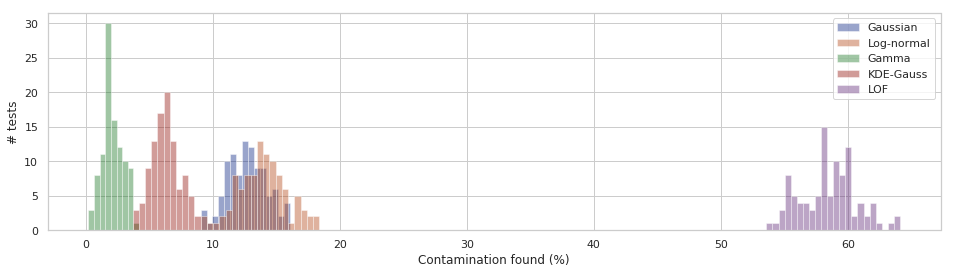

In [19]:
sns.set(style='whitegrid', palette='dark')
f, ax = plt.subplots(figsize=(16,4))

bin_size = 0.5
for model in models:
    results = model['results']
    print('Média %s: %.2lf%%' % (model['name'], np.mean(results)))
    bins = max(1, int((max(results) - min(results)) // bin_size) + 1)
    sns.distplot(results, label=model['name'], kde=False, bins=bins)

plt.legend(frameon=True)
plt.xlabel('Contamination found (%)')
plt.ylabel('# tests')
plt.grid(True)

---
## Resultados e Conclusões

Os modelos de Distribuição Gaussiana e Log-Normal apresentaram os melhores resultados tanto em termos de acurácia quanto em termos de desempenho, sendo as opções mais adequadas ao contexto, apesar de apresentar um taxa de contaminação um ponto menos precisa, o modelo Log-Normal se ajustou muito bem aos dados e pode ser considerada a melhor opção para o contexto. O KDE apresentou resultados bons, contudo, obteve um desempenho ruim, chegando a ser 20 vezes mais lento que o Gaussiano na etapa de treinamento e 100 vezes mais lento na etapa de teste.

O modelo Gamma apresentou uma taxa média de contaminação muito baixa e assim, não é adequado para o contexto. O modelo LOF apresentou uma taxa de contaminação muito elevada e rotulou valores altos de "razão de valor comprovado por valor captado" como outliers, o que não parece fazer sentido para o contexto.